In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conn = sqlite3.connect("../db/baltasar.db")
def sql(query):
    #print(query)
    return pd.read_sql_query(query, conn)

In [25]:
results = sql('''
SELECT
    (SELECT count(*) as numUnique
    FROM
        (SELECT 
            name
        FROM
            QuasiIdentifiers
        GROUP BY exchange
        HAVING count(*) = 1)) as exchangeUnique,
    (SELECT count(*) as numUnique
    FROM
        (SELECT 
            name
        FROM
            QuasiIdentifiers
        GROUP BY taxonomy
        HAVING count(*) = 1)) as taxonomyUnique,
    (SELECT count(*) as numUnique
    FROM
        (SELECT 
            name
        FROM
            QuasiIdentifiers
        GROUP BY token
        HAVING count(*) = 1)) as tokenUnique,
    (SELECT count(*) as numUnique
    FROM
        (SELECT 
            name
        FROM
            QuasiIdentifiers
        GROUP BY token, exchange
        HAVING count(*) = 1)) as tokenAndExchange,
    (SELECT count(*) as numUnique
    FROM
        (SELECT 
            name
        FROM
            QuasiIdentifiers
        GROUP BY token, taxonomy
        HAVING count(*) = 1)) as tokenAndTaxonomy,
    (SELECT count(*) as numUnique
    FROM
        (SELECT 
            name
        FROM
            QuasiIdentifiers
        GROUP BY taxonomy, exchange
        HAVING count(*) = 1)) as taxonomyAndExchange,
    (SELECT count(*) as numUnique
    FROM
        (SELECT 
            name
        FROM
            QuasiIdentifiers
        GROUP BY taxonomy, exchange,token
        HAVING count(*) = 1)) as allKnowledge
''')
results

,exchangeUnique,taxonomyUnique,tokenUnique,tokenAndExchange,tokenAndTaxonomy,taxonomyAndExchange,allKnowledge
0,36876,42650,533877,646864,1146069,404056,1260420


In [26]:
results10 = sql('''
SELECT
    (SELECT sum(numAddresses) as numUnique
    FROM
        (SELECT 
            name, count(*) as numAddresses
        FROM
            QuasiIdentifiers
        GROUP BY exchange
        HAVING count(*) <= 10)) as exchangeUnique,
    (SELECT sum(numAddresses) as numUnique
    FROM
        (SELECT 
            name, count(*) as numAddresses
        FROM
            QuasiIdentifiers
        GROUP BY taxonomy
        HAVING count(*) <= 10)) as taxonomyUnique,
    (SELECT sum(numAddresses) as numUnique
    FROM
        (SELECT 
            name, count(*) as numAddresses
        FROM
            QuasiIdentifiers
        GROUP BY token
        HAVING count(*) <= 10)) as tokenUnique,
    (SELECT sum(numAddresses) as numUnique
    FROM
        (SELECT 
            name, count(*) as numAddresses
        FROM
            QuasiIdentifiers
        GROUP BY token, exchange
        HAVING count(*) <= 10)) as tokenAndExchange,
    (SELECT sum(numAddresses) as numUnique
    FROM
        (SELECT 
            name, count(*) as numAddresses
        FROM
            QuasiIdentifiers
        GROUP BY token, taxonomy
        HAVING count(*) <= 10)) as tokenAndTaxonomy,
    (SELECT sum(numAddresses) as numUnique
    FROM
        (SELECT 
            name, count(*) as numAddresses
        FROM
            QuasiIdentifiers
        GROUP BY taxonomy, exchange
        HAVING count(*) <= 10)) as taxonomyAndExchange,
    (SELECT sum(numAddresses) as numUnique
    FROM
        (SELECT 
            name, count(*) as numAddresses
        FROM
            QuasiIdentifiers
        GROUP BY taxonomy, exchange,token
        HAVING count(*) <= 10)) as allKnowledge
''')
results10

,exchangeUnique,taxonomyUnique,tokenUnique,tokenAndExchange,tokenAndTaxonomy,taxonomyAndExchange,allKnowledge
0,73627,229671,732014,868571,1725442,868210,1844796


# Other Quasi-Identifiers

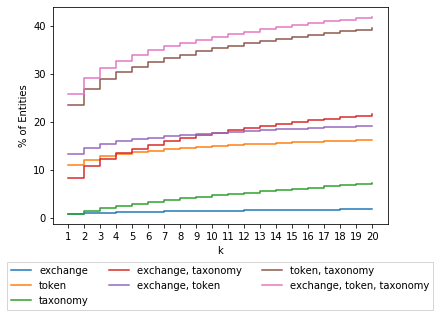

In [50]:
allAddresses = sql('''SELECT count(*) as c FROM QuasiIdentifiers''').c[0]

def makeLinePlot(groupByStatement, label):
    data = sql('''
    SELECT
        k, sum(k) as numMatches
    FROM
        (SELECT 
            count(*) as k
        FROM
            QuasiIdentifiers
        GROUP BY '''+groupByStatement+''') as exchangeUnique
    WHERE k <= 20
    GROUP BY k
    ORDER BY k
    ''')

    data['matchedPerc'] = 100 * data['numMatches'] / allAddresses
    data['matchedCum'] = data['matchedPerc'].cumsum()
    sns.lineplot(data=data, x="k", y='matchedCum', label=label, drawstyle='steps-post')
    
groupByStatements = ["exchange", "token", "taxonomy", "exchange, taxonomy", "exchange, token", "token, taxonomy", "exchange, token, taxonomy"]
for statement in groupByStatements:
    makeLinePlot(statement,statement)
plt.ylabel('% of Entities')
lgd = plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=3, fancybox=False, shadow=False)
plt.xticks(np.arange(1, 21, step=1))
plt.savefig('graphs/eva_kanon.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Dimensions

NameError: name 'lgd' is not defined

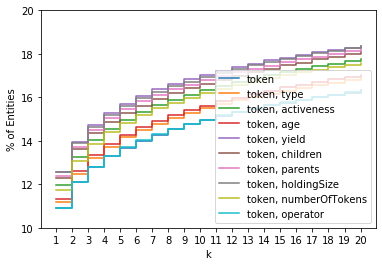

In [3]:
allAddresses = sql('''SELECT count(*) as c FROM QuasiIdentifiers''').c[0]
def makeLinePlot(groupByStatement, label):
    data = sql('''
    SELECT
        k, sum(k) as numMatches
    FROM
        (SELECT 
            count(*) as k
        FROM
            QuasiIdentifiers
            NATURAL JOIN
            EntityTaxonomy
        WHERE blocknumber = (SELECT max(blocknumber) FROM EntityTaxonomy)
        GROUP BY '''+groupByStatement+''') as exchangeUnique
    WHERE k <= 20
    GROUP BY k
    ORDER BY k
    ''')

    data['matchedPerc'] = 100 * data['numMatches'] / allAddresses
    data['matchedCum'] = data['matchedPerc'].cumsum()
    sns.lineplot(data=data, x="k", y='matchedCum', label=label, drawstyle='steps-post')
    
groupByStatements = ["token", 
                     "token, type", 
                      "token, activeness", 
                      "token, age", 
                      "token, yield", 
                      "token, children", 
                      "token, parents", 
                      "token, holdingSize", 
                      "token, numberOfTokens", 
                      "token, operator", 
                    ]
for statement in groupByStatements:
    makeLinePlot(statement,statement)
plt.ylabel('% of Entities')
axes = plt.gca()
axes.set_ylim([10,20])
plt.xticks(np.arange(1, 21, step=1))
plt.savefig('graphs/eva_kanon_dimensions.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [9]:
d = sql('''
SELECT
        k, sum(k) as numMatches
    FROM
        (SELECT 
            count(*) as k
        FROM
            QuasiIdentifiers
            NATURAL JOIN
            EntityTaxonomy
        WHERE blocknumber = 7680001 and name LIKE "0x0%"
        GROUP BY token) as exchangeUnique
    WHERE k <= 20
    GROUP BY k
    ORDER BY k
''')

In [5]:
sql('''SELECT max(blocknumber) FROM EntityTaxonomy''')

,max(blocknumber)
0,7680001
